In [72]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data1 = pd.read_csv('C:/Python Data/dataset/4차년도.csv', encoding='cp949')
data2 = pd.read_csv('C:/Python Data/dataset/5차년도.csv', encoding='cp949')
data3 = pd.read_csv('C:/Python Data/dataset/5차년도_2차.csv', encoding='cp949')

In [ ]:
def sentiment_str_lower(data):
    data['1번 감정'] = data['1번 감정'].apply(str.lower)
    data['2번 감정'] = data['2번 감정'].apply(str.lower)
    data['3번 감정'] = data['3번 감정'].apply(str.lower)
    data['4번 감정'] = data['4번 감정'].apply(str.lower)
    data['5번 감정'] = data['5번 감정'].apply(str.lower)

def sentiment_condition_setting(data):
    for i in range(len(data)):
        if data['상황'][i] == 'anger':
            data['상황'][i] = 'angry'
        if data['상황'][i] == 'sad':
            data['상황'][i] = 'sadness' 

for data in [data1, data2, data3]:
   sentiment_str_lower(data)
   sentiment_condition_setting(data)

In [4]:
def get_keys(dic, cond): #returns a key for max values in dic
  key_list = list(dic.keys())
  val_list = list(dic.values())
  max_value = max(val_list)
  index1 = val_list.index(max_value)

  if max_value >= 3:
    return key_list[val_list.index(max_value)]
  
  elif max_value == 2:
    index2 = -1
    for i in range(len(val_list)):
      if i == index1:
        continue
      if val_list[i] == 2:
        index2 = i
        break
    if index2 != -1:
      dic[cond] += 1
      val_list2 = list(dic.values())
      max_value = max(val_list2)
      return key_list[val_list2.index(max_value)]
    else:
      return key_list[val_list.index(max_value)]
    
  elif max_value == 1:
    dic[cond] += 1
    val_list2 = list(dic.values())
    max_value = max(val_list2)
    return key_list[val_list2.index(max_value)]


def cal_sentiment(data):
  final_label = []

  for i in range(len(data)):
    sentiments = {'neutral':0, 'happiness':0, 'surprise':0, 'fear': 0, 'disgust':0, 'angry':0, 'sadness':0}

    sentiments[data.iloc[i]['1번 감정']] += 1
    sentiments[data.iloc[i]['2번 감정']] += 1
    sentiments[data.iloc[i]['3번 감정']] += 1
    sentiments[data.iloc[i]['4번 감정']] += 1
    sentiments[data.iloc[i]['5번 감정']] += 1
    final_label.append(get_keys(sentiments, data.iloc[i]['상황']))
  
  final_label_df = pd.DataFrame(final_label, columns=['final_label'])
  new_data = pd.concat([data[['wav_id', '발화문']], final_label_df], axis = 1)
  return new_data

# 적절한 감정 결정
new_data1 = cal_sentiment(data1)
new_data2 = cal_sentiment(data2)
new_data3 = cal_sentiment(data3)

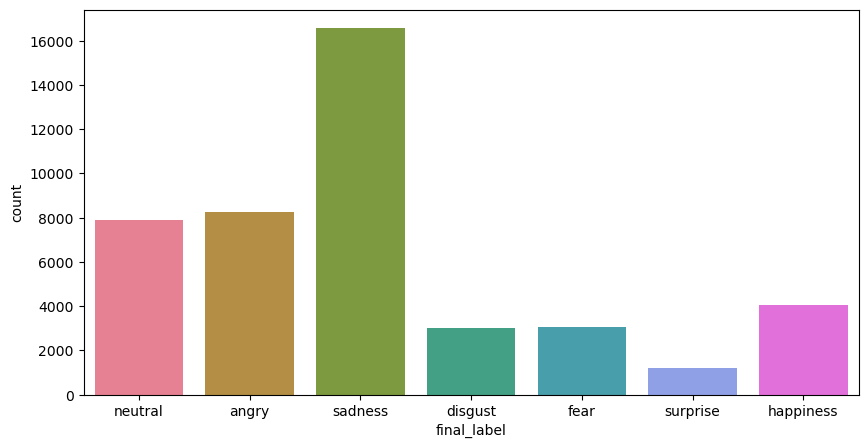

In [5]:
new_data_df = pd.concat([new_data1, new_data2, new_data3], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = new_data_df['final_label'], palette = "husl",  ax = ax)
plt.show()

In [6]:
def preprocessing_data(data):
    neutral_list, happiness_list, fear_list, disgust_list, angry_list, sadness_list = [],[],[],[],[],[]

    for i in range(len(data)):
        if data.iloc[i]['final_label'] == 'neutral':
            neutral_list.append(data.iloc[i])
        elif data.iloc[i]['final_label'] == 'happiness':
            happiness_list.append(data.iloc[i])
        elif data.iloc[i]['final_label'] == 'fear':
            fear_list.append(data.iloc[i])
        elif data.iloc[i]['final_label'] == 'disgust':
            disgust_list.append(data.iloc[i])
        elif data.iloc[i]['final_label'] == 'angry':
            angry_list.append(data.iloc[i])
        elif data.iloc[i]['final_label'] == 'sadness':
            sadness_list.append(data.iloc[i])
    
    return neutral_list, happiness_list, fear_list, disgust_list, angry_list, sadness_list

def generate_new_dataframe(data, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6):
    l1, l2, l3, l4, l5, l6 = preprocessing_data(data)
    l1 = random.sample(l1, alpha1)
    l2 = random.sample(l2, alpha2)
    l3 = random.sample(l3, alpha3)
    l4 = random.sample(l4, alpha4)
    l5 = random.sample(l5, alpha5)
    l6 = random.sample(l6, alpha6)
    pd1 = pd.DataFrame(l1, columns=['wav_id', '발화문', 'final_label'])
    pd2 = pd.DataFrame(l2)
    pd3 = pd.DataFrame(l3)
    pd4 = pd.DataFrame(l4)
    pd5 = pd.DataFrame(l5)
    pd6 = pd.DataFrame(l6)
    return pd.concat([pd1, pd2, pd3, pd4, pd5, pd6], ignore_index=True)

# 모든 감정 데이터 개수를 3000개로 통일
new_data_df1 = generate_new_dataframe(new_data1, 400, 30, 958, 1039, 1800, 1300)
new_data_df2 = generate_new_dataframe(new_data2, 100, 70, 1009, 312, 700, 1100)
new_data_df3 = generate_new_dataframe(new_data3, 2500, 2900, 1033, 1649, 500, 600)

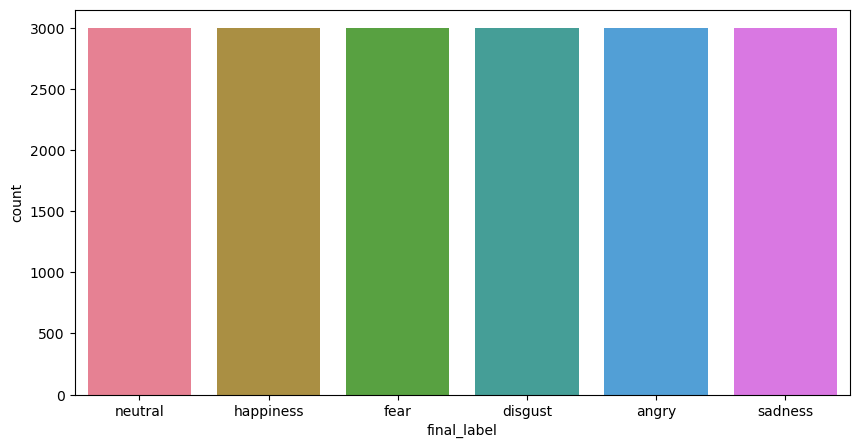

In [7]:
new_data_df = pd.concat([new_data_df1, new_data_df2, new_data_df3], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = new_data_df['final_label'], palette = "husl",  ax = ax)
plt.show()

In [ ]:
def replace_label(data_df):
    df = data_df[['발화문','final_label']]
    df.loc[(df['final_label'] == "fear"), 'final_label'] = 0  #공포 => 0
    df.loc[(df['final_label'] == "angry"), 'final_label'] = 1  #분노 => 1
    df.loc[(df['final_label'] == "sadness"), 'final_label'] = 2  #슬픔 => 2
    df.loc[(df['final_label'] == "neutral"), 'final_label'] = 3  #중립 => 3
    df.loc[(df['final_label'] == "happiness"), 'final_label'] = 4  #행복 => 4
    df.loc[(df['final_label'] == "disgust"), 'final_label'] = 5  #혐오 => 5
    return df

df1 = replace_label(new_data_df1)
df2 = replace_label(new_data_df2)
df3 = replace_label(new_data_df3)

In [9]:
class text_embedding():
  def __init__(self, model_name):
    self.model_name = model_name

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    embedding_model = SentenceTransformer(self.model_name)
    embedding_vec = embedding_model.encode(X['발화문'])
    X_val = np.concatenate((X.drop(['final_label', '발화문'], axis = 1), embedding_vec), axis = 1)
    return X_val

In [10]:
text_df = pd.concat([df1, df2, df3], ignore_index=True)
text_df.to_csv('C:/Python Data/final csv/text_df.csv', encoding='utf-8-sig')

final_df = pd.read_csv('C:/Python Data/final csv/text_df.csv', index_col=0)

In [11]:
pre_trained_models = 'jhgan/ko-sbert-multitask'

txt_embed = text_embedding(model_name = pre_trained_models)
X = txt_embed.transform(final_df)
y = final_df['final_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

In [14]:
clf = SVC(C=1, kernel = 'rbf', probability=True)
clf.fit(X_train_scaled, y_train)

SVC(C=1, probability=True)

In [16]:
# 성능 평가
print(f'train-score: {clf.score(X_train_scaled, y_train)}')
print(f'test-score: {clf.score(X_test_scaled, y_test)}')
y_pred = clf.predict(X_test_scaled)
print(f'accuracy: {accuracy_score(y_test, y_pred)}')

train-score: 0.8831111111111111
test-score: 0.8144444444444444
accuracy: 0.8144444444444444


Text(0.5, 1.0, 'Emotion by Text (Accuracy)')

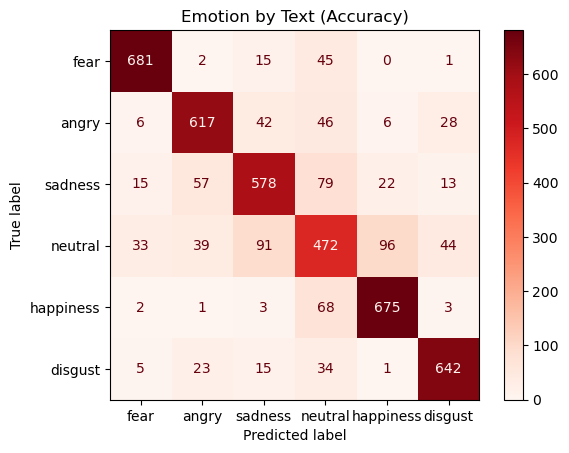

In [19]:
# 혼동행렬
cm = confusion_matrix(y_test, y_pred, normalize='true')
label = ['fear', 'angry', 'sadness', 'neutral', 'happiness', 'disgust']
disp = ConfusionMatrixDisplay.from_estimator(clf,
                        X_test_scaled, y_test,
                        display_labels=label,
                        cmap = plt.cm.Reds,
                        normalize=None)

disp.ax_.set_title('Emotion by Text (Accuracy)')

In [80]:
with open('C:/Python Data/variable/text_scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
joblib.dump(clf, 'C:/Python Data/model/text_svc_model.pkl')

with open('C:/Python Data/variable/text_scaler.pickle', 'rb') as f:
    new_scaler = pickle.load(f)
model = joblib.load('C:/Python Data/model/text_svc_model.pkl')

In [81]:
txt = '아침에 늦잠을 자서 헬스장에 가지를 못했네...'
print(txt)

d = pd.DataFrame(columns=['발화문', 'final_label'])
d.loc[0] = [txt,'']
t = txt_embed.transform(d)
t_scaled = new_scaler.transform(t)

# 0:공포  1:분노  2:슬픔  3:중립  4:행복   5:혐오
result = model.predict_proba(t_scaled)
emotion_dict = {'공포': str(round(result[0][0]*100,2))+'%', '분노': str(round(result[0][1]*100,2))+'%',
                '슬픔': str(round(result[0][2]*100,2))+'%', '중립': str(round(result[0][3]*100,2))+'%',
                '행복': str(round(result[0][4]*100,2))+'%', '혐오': str(round(result[0][5]*100,2))+'%'}
final_emotion = ''

if np.argmax(result) == 0:
    final_emotion = '공포'
elif np.argmax(result) == 1:
    final_emotion = '분노'
elif np.argmax(result) == 2:
    final_emotion = '슬픔'
elif np.argmax(result) == 3:
    final_emotion = '중립'
elif np.argmax(result) == 4:
    final_emotion = '행복'
elif np.argmax(result) == 5:
    final_emotion = '혐오'

print(emotion_dict)
print(f'최종 감정: {final_emotion}')

아침에 늦잠을 자서 헬스장에 가지를 못했네...
{'공포': '5.69%', '분노': '3.02%', '슬픔': '80.11%', '중립': '5.86%', '행복': '0.8%', '혐오': '4.52%'}
최종 감정: 슬픔
